In [1]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as dt
import utils.dlc_bci as bci
from IPython.display import clear_output
import time

In [2]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.T = 500
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 14, (1, 28), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(14, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((14, 16, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        # FC Layer
        self.fc1 = nn.Linear(248, 1)
        

    def forward(self, x):
        # Layer 1
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.50)
        x = x.permute(0, 3, 1, 2)
        
        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.50)
        x = self.pooling2(x)
        
        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.50)
        x = self.pooling3(x)
        
        # FC Layer
        x = x.view(-1, 248)
        x = F.sigmoid(self.fc1(x))
        return x

In [23]:
# Hyperparams
batch_size = 1
num_epochs = 20

# Loading data
train_input , train_target = bci.load(root='../../data_bci', one_khz = True)
test_input , test_target = bci.load ( root = '../../data_bci', train = False, one_khz = True)
train_input = train_input.view(train_input.shape[0], 1, 28, 500).permute(0,1,3,2)
test_input = test_input.view(test_input.shape[0], 1, 28, 500).permute(0,1,3,2)

# Preparing dataset
train_dataset = dt.TensorDataset(train_input, train_target)
test_dataset = dt.TensorDataset(test_input, test_target)
train_loader = dt.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
test_loader = dt.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

# Loading net
net = EEGNet()

# Setting loss function
criterion = nn.BCELoss()

# Setting optimizer
optimizer = optim.Adam(net.parameters())

best_accuracy = 0
# Training
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print("\n ------ Epoch n°", epoch + 1, "/",num_epochs,"------")
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = Variable(inputs)
        labels = Variable(labels.float().view(batch_size, 1))
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward(retain_graph=True)
        optimizer.step()
        running_loss += loss.data[0]
        
    print ("\t• Training Loss ", running_loss)
    
    # Evaluating on testing dataset
    evaluate("\t\t- Train", net, train_loader)
    
    # Returning best test accuracy
    best_accuracy = evaluate("\t\t- Test", net, test_loader, testing=True, best_accuracy=best_accuracy) 


 ------ Epoch n° 1 / 20 ------
	• Training Loss  222.10995173454285
		- Train  accuracy of the model : 49 %
		- Test  accuracy of the model : 50 %

 ------ Epoch n° 2 / 20 ------
	• Training Loss  221.7818678803732
		- Train  accuracy of the model : 61 %
		- Test  accuracy of the model : 44 %

 ------ Epoch n° 3 / 20 ------
	• Training Loss  262.8829723326479
		- Train  accuracy of the model : 61 %
		- Test  accuracy of the model : 47 %

 ------ Epoch n° 4 / 20 ------
	• Training Loss  219.66182889416814
		- Train  accuracy of the model : 62 %
		- Test  accuracy of the model : 56 %

 ------ Epoch n° 5 / 20 ------
	• Training Loss  213.036969602108
		- Train  accuracy of the model : 69 %
		- Test  accuracy of the model : 55 %

 ------ Epoch n° 6 / 20 ------
	• Training Loss  196.42471528053284
		- Train  accuracy of the model : 79 %
		- Test  accuracy of the model : 67 %

 ------ Epoch n° 7 / 20 ------
	• Training Loss  166.6947866184637
		- Train  accuracy of the model : 74 %
		- Test

# Structure of the net

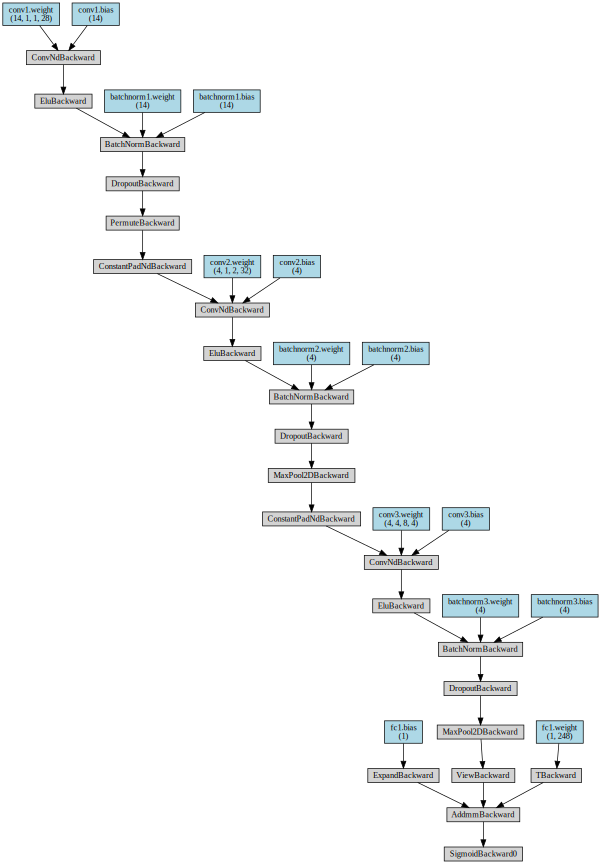

In [24]:
from torchviz import make_dot
make_dot(outputs, params=dict(net.named_parameters()))

# Evaluating model

In [5]:
def evaluate(label, net, loader, testing=False, best_accuracy=0):
    # Test the Model
    net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0
    total = 0
    for inputs, labels in loader:
        inputs = Variable(inputs)
        labels = labels.float().view(batch_size, 1)
        outputs = net(inputs)
        predicted = torch.round(outputs.data)
        total += labels.size(0)
        correct += (predicted == labels.float()).sum()
    
    accuracy = (100 * correct / total)
    print(label, ' accuracy of the model : %d %%' % accuracy)

    # Save the Trained Model
    if testing:
        if best_accuracy <= accuracy:
            best_accuracy = accuracy
            torch.save(net.state_dict(), '../../model/eegnet.pkl')
        return best_accuracy